<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%8F%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰의 가속도 센서 데이터로 분류하는 예

In [0]:
# from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
# from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

## 여섯개의 레이블을 사용한다.
- Downstairs, Jogging, Sitting, Standing, Upstairs, Walking
### 아래 변수를 정의한다.
- TIME_PERIODS stores the length of the time segment. 
- STEP_DISTANCE determines the amount of overlap between two consecutive time segments


In [0]:
# 소수점 두자리만 표시
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(precision=2)

# sns.set() # seaborn 디폴트 설정 선택
# plt.style.use('ggplot')
# print('keras version ', keras.__version__)
# 레이블
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# 하나의 분석 단위 세그먼트 크기
TIME = 80
# 연속한 세그먼트 간에 떨어진 크기
# 이 값이 TIME_PERIODS와 같으면 겹치는 영역이 없다는 뜻
# 여기서는 40 단위로 움직이면서 판독을 한다.
# STEP_DISTANCE = 40

In [3]:
import os, os.path, shutil
if not os.path.exists("./data"):
    os.makedirs("./data")
!curl http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz \
 -o ./data/WISDM_ar_latest.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  4501k      0  0:00:02  0:00:02 --:--:-- 4499k


In [0]:
fname = './data/WISDM_ar_latest.tar.gz'

import tarfile
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall('./data')
    tar.close()

In [5]:
!head -5 ./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [0]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # 마지막 컬럼에서 ";"를 삭제
  
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # 모두 소수로 변환 (현재 문자열로 바뀌어 있음)
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
#     결측치 처리 (중요!)
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
# Load data set containing all the data from csv
df = read_data('./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [0]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.69,12.68,0.50
1,33,Jogging,49106062271000,5.01,11.26,0.95
2,33,Jogging,49106112167000,4.90,10.88,-0.08
3,33,Jogging,49106222305000,-0.61,18.50,3.02
4,33,Jogging,49106332290000,-1.18,12.11,7.21


In [0]:
df.shape

(1098203, 6)

In [0]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

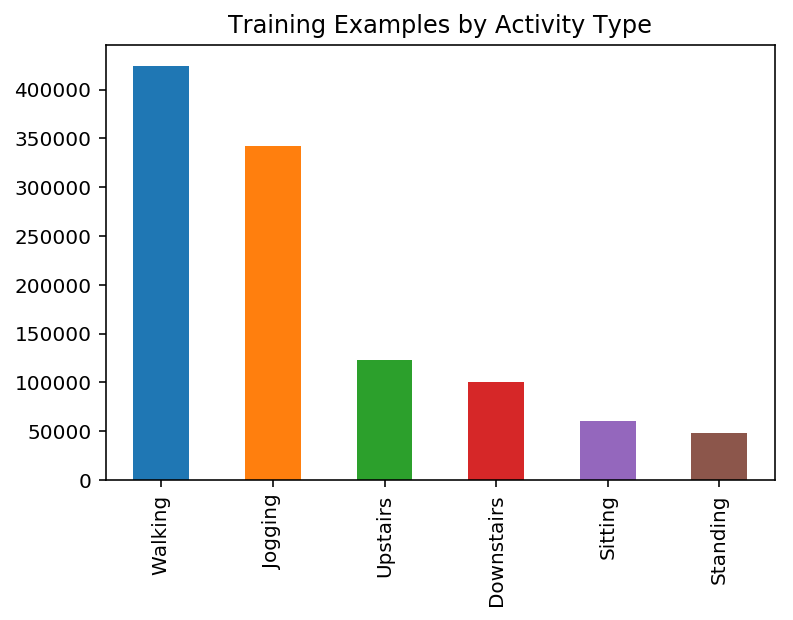

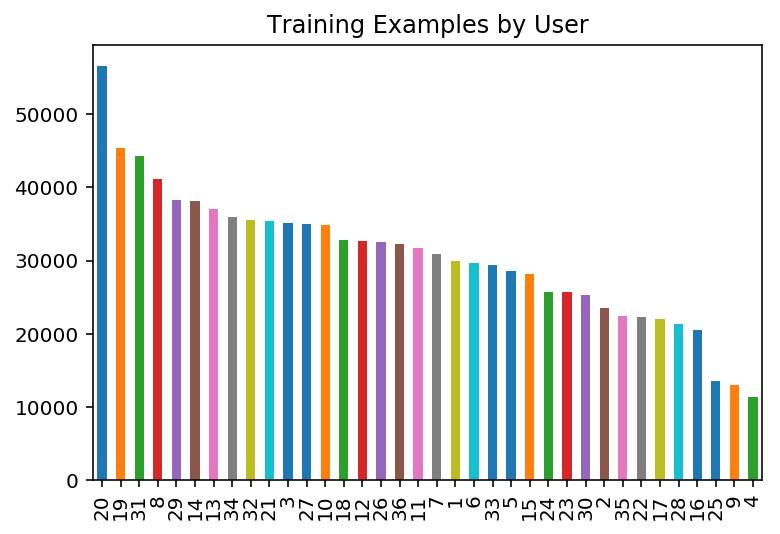

In [0]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                              title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                             title='Training Examples by User')
plt.show()

In [0]:
df.shape

(1098203, 6)

In [7]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

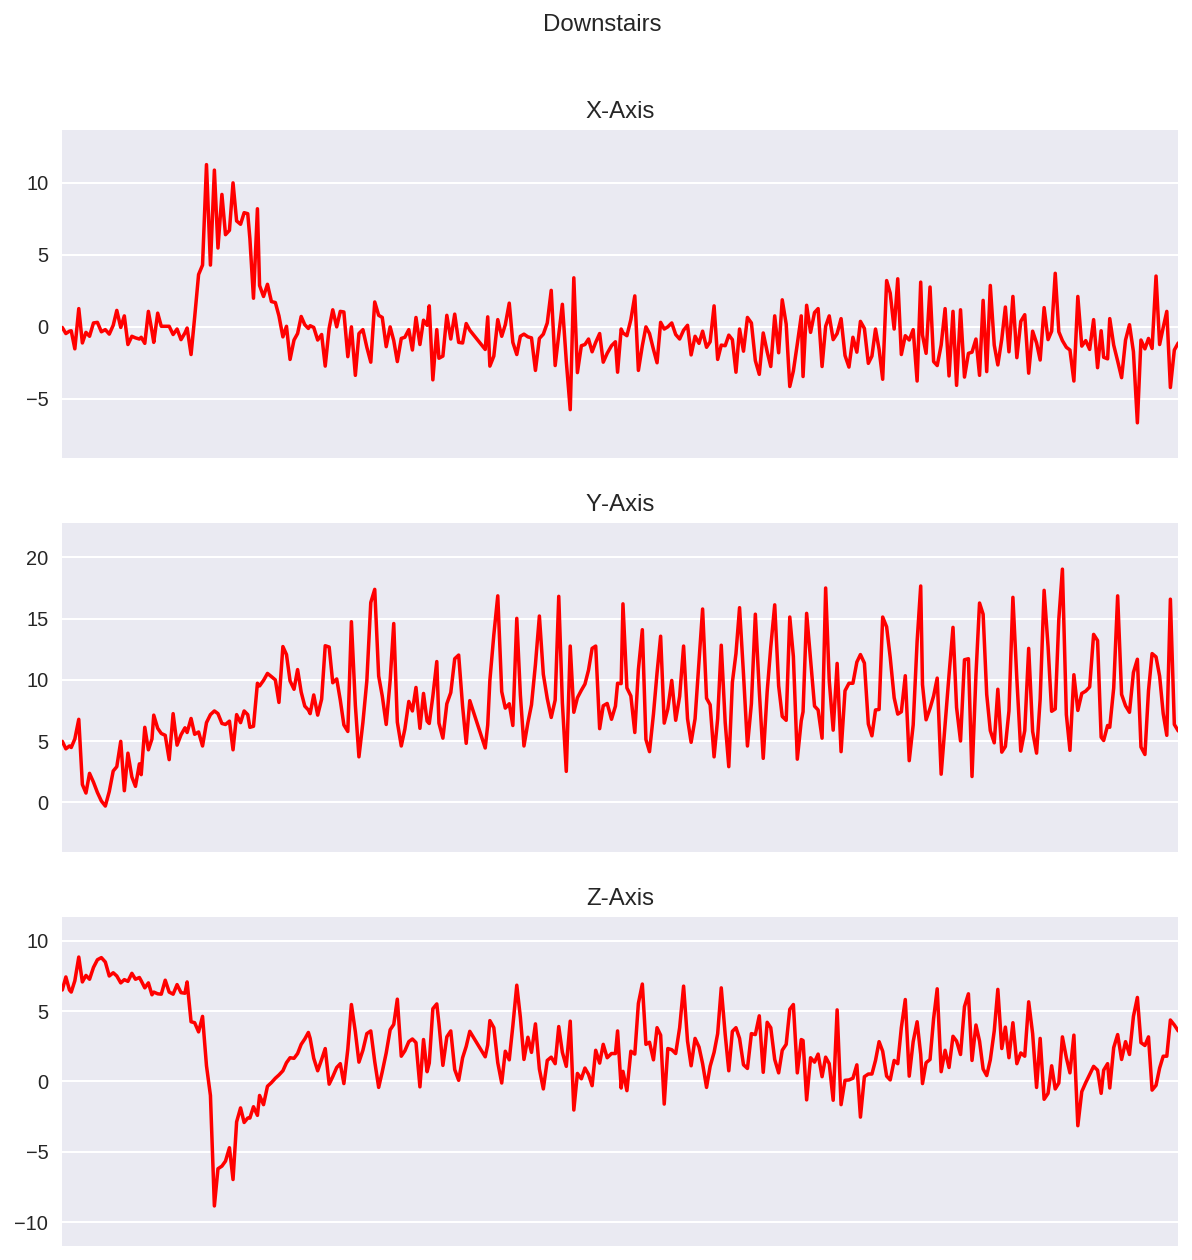

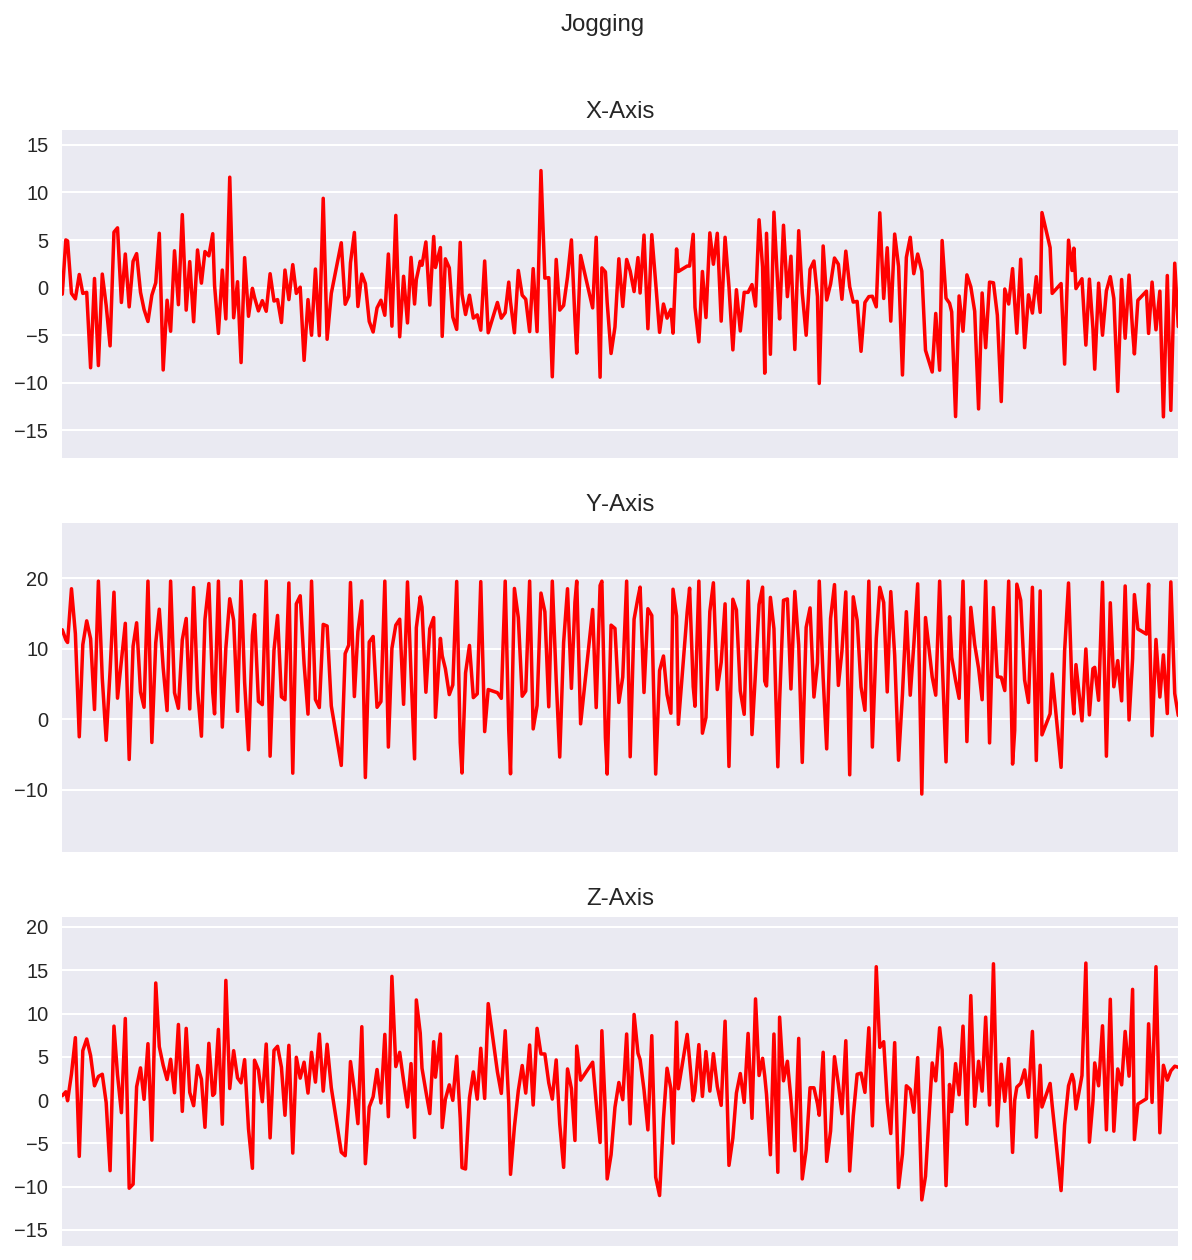

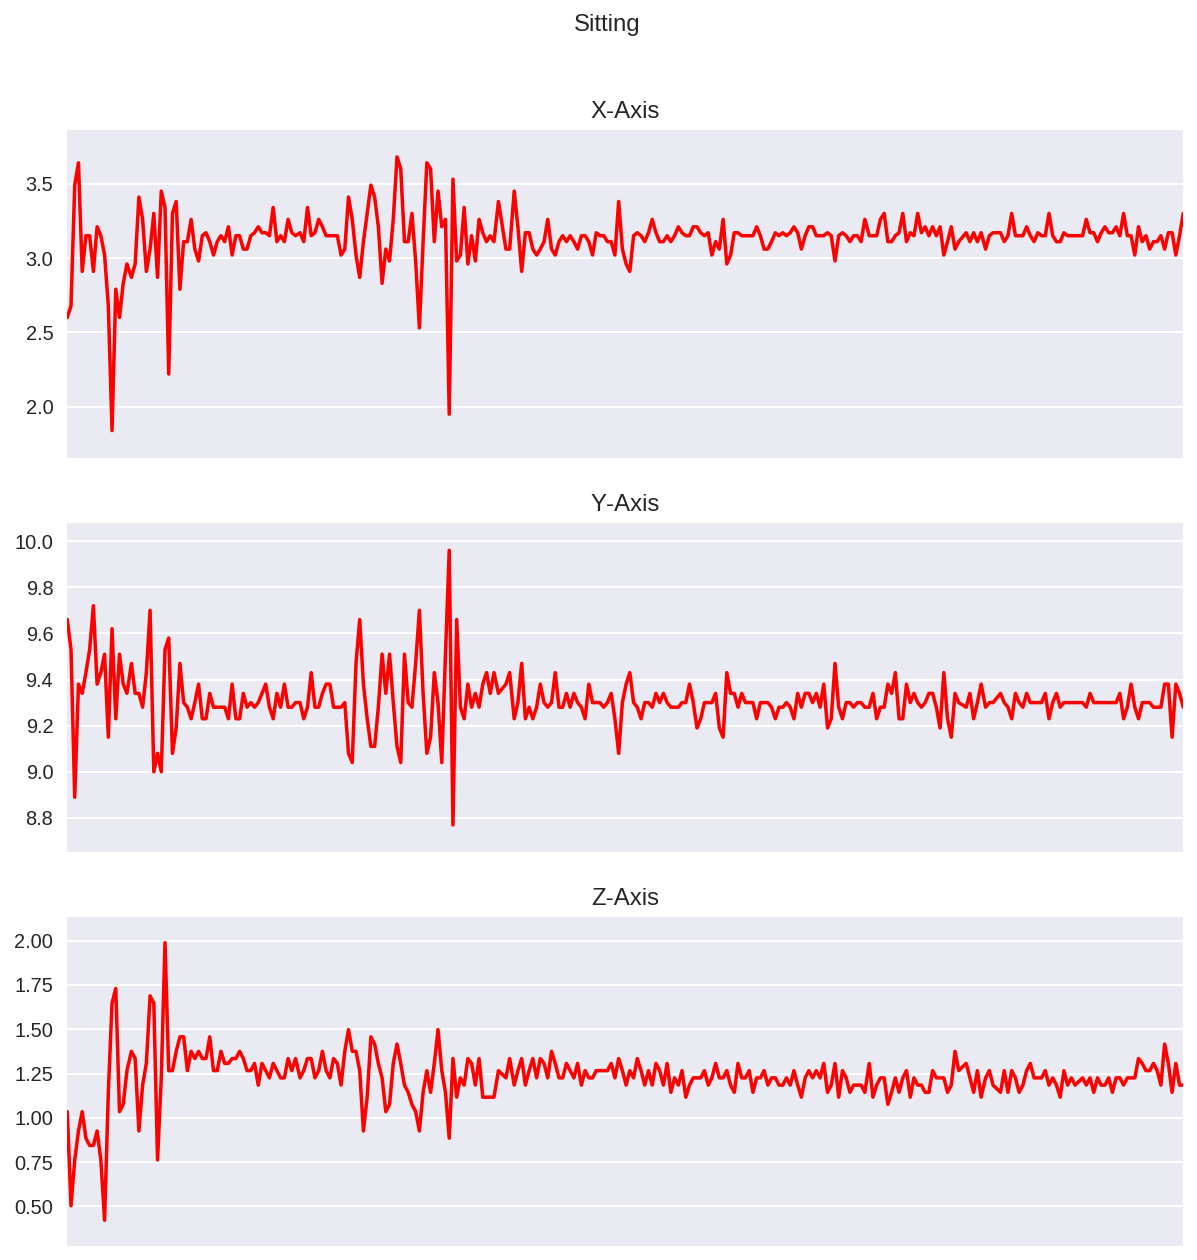

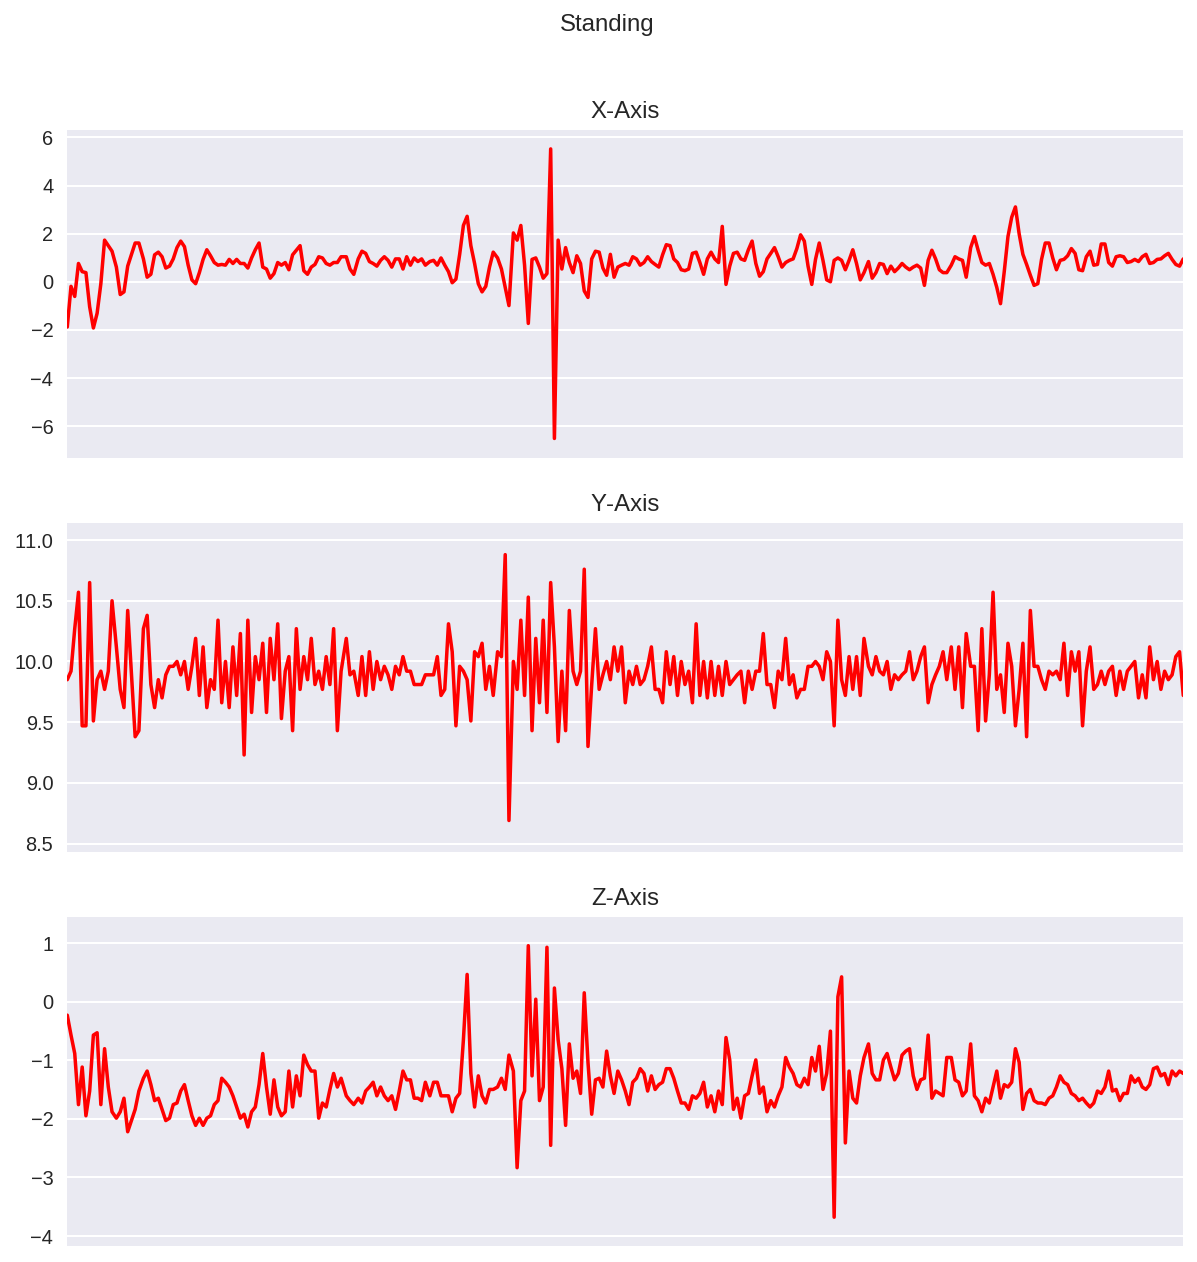

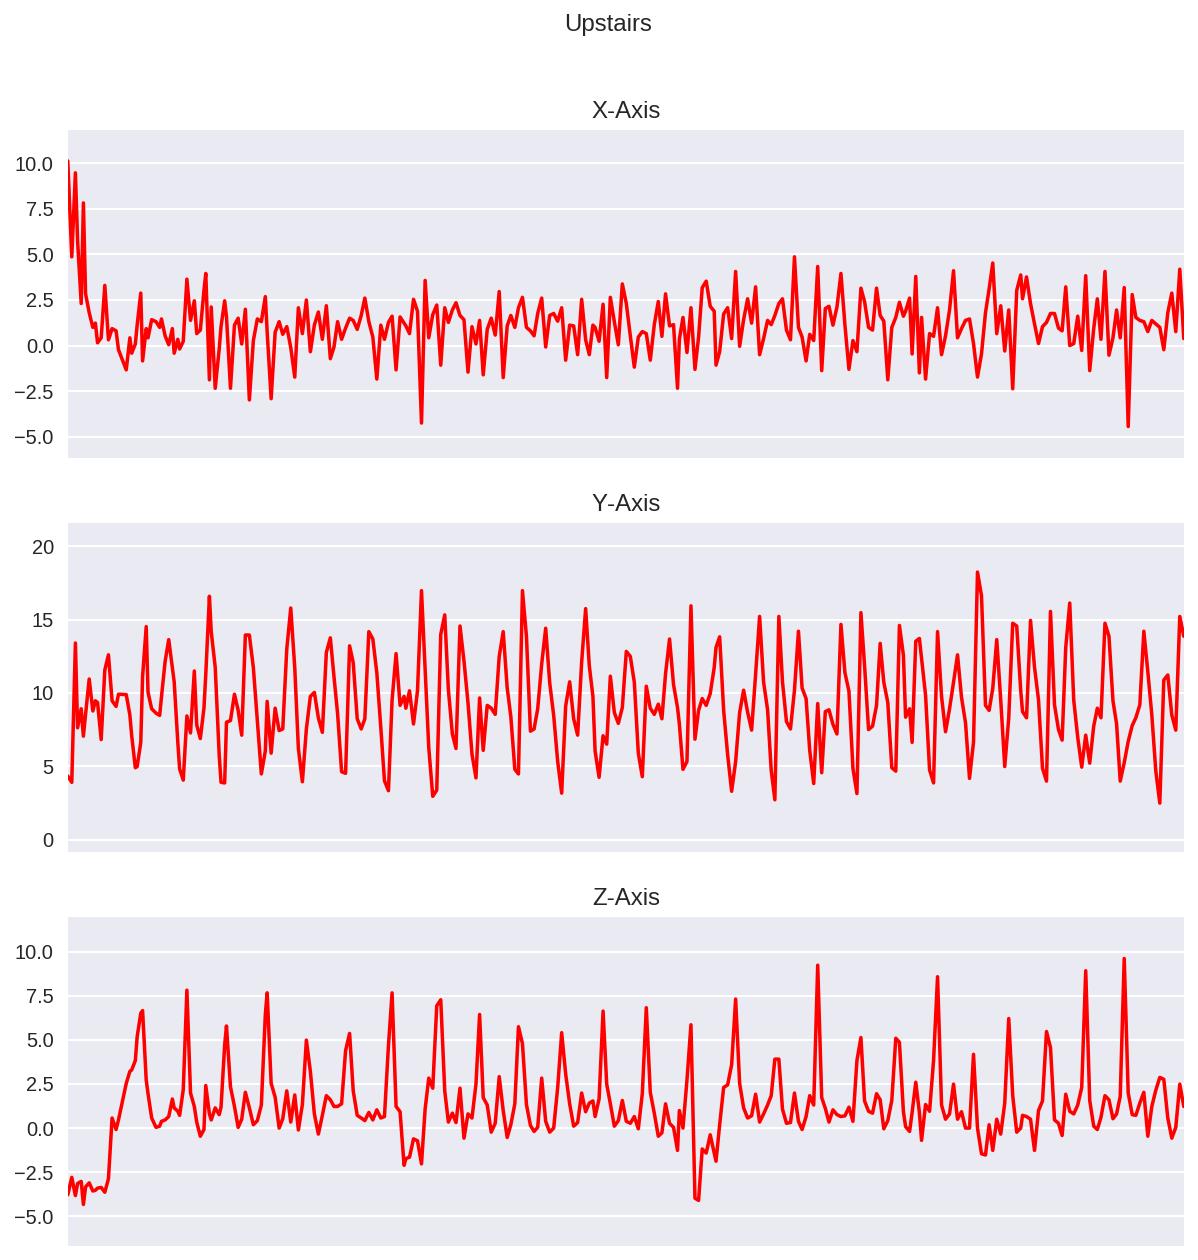

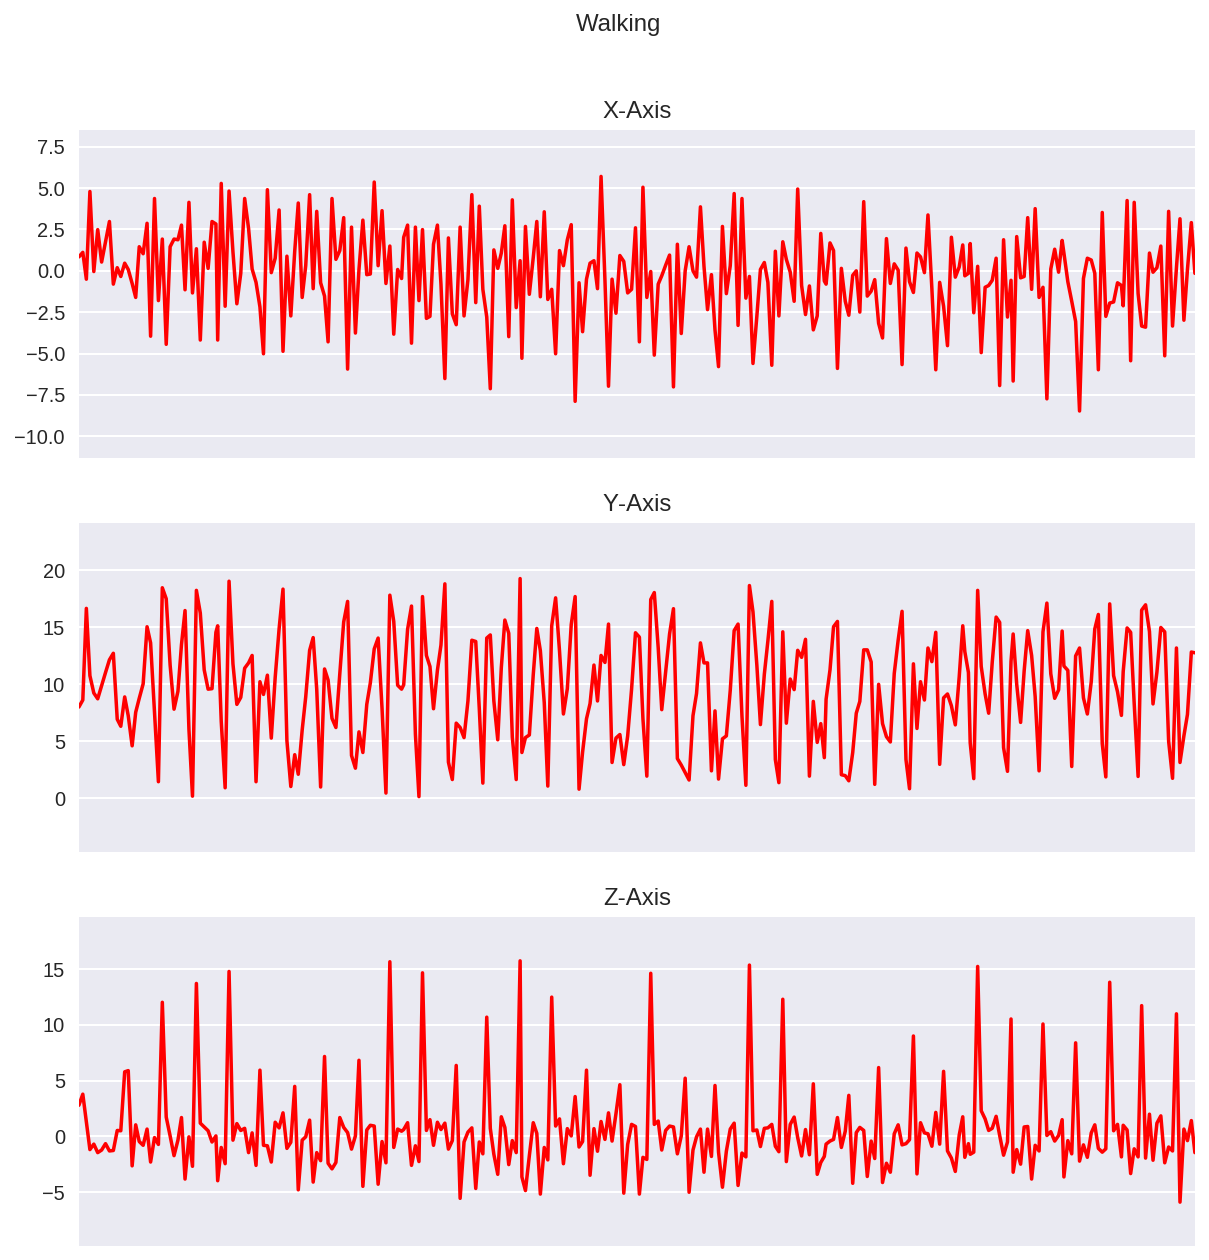

In [8]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

In [0]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values)

In [0]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.69,12.68,0.50,1
1,33,Jogging,49106062271000,5.01,11.26,0.95,1
2,33,Jogging,49106112167000,4.90,10.88,-0.08,1


In [10]:
df['activity'].value_counts()

Walking       423905
Jogging       330330
Upstairs      122598
Downstairs    100194
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [11]:
z = stats.mode(df['ActivityEncoded'][0:80])
act, count = z[0][0], z[1][0]
count

80

In [0]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'ActivityEncoded'],
      dtype='object')

In [12]:
df = df[['x-axis', 'y-axis', 'z-axis','ActivityEncoded']]
df[:2]


,x-axis,y-axis,z-axis,ActivityEncoded
0,-0.69,12.68,0.50,1
1,5.01,11.26,0.95,1


In [0]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [0]:
df[:2]

,x-axis,y-axis,z-axis,ActivityEncoded
0,-0.20,0.79,0.02,1
1,0.63,0.58,0.11,1


In [0]:
# N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다 
N = 100
X_all = []
y = []
for i in range(0, (len(df) - N +1), N):
    z = stats.mode(df['ActivityEncoded'][i: i+N])
    act, count = z[0][0], z[1][0]
    if count == N:
        xs = df['x-axis'].values[i: i + N]
        ys = df['y-axis'].values[i: i + N]
        zs = df['z-axis'].values[i: i + N]
        X_all.append([xs, ys, zs])
        y.append(act)

    # Bring the segments into a better shape
X_all = np.asarray(X_all, dtype= np.float32).reshape(-1, 3, N)
y = np.asarray(y)

In [16]:
# x-axis 성분만 추출
X = X_all[:,2,:]
X[:2]

array([[ 1.84e-02,  1.12e-01, -1.04e-01,  5.45e-01,  1.42e+00, -1.45e+00,
         1.11e+00,  1.39e+00,  9.87e-01,  2.58e-01,  4.83e-01,  5.37e-01,
        -1.50e-01, -1.79e+00,  1.70e+00,  5.23e-01, -3.92e-01,  1.88e+00,
        -2.22e+00, -2.12e+00,  2.35e-01,  6.91e-01, -6.99e-02,  1.27e+00,
        -1.06e+00,  2.74e+00,  1.20e+00,  7.53e-01,  4.09e-01,  8.99e-01,
         8.96e-02,  1.74e+00, -3.60e-01,  1.64e+00,  9.82e-02, -2.24e-01,
         7.48e-01,  4.17e-01, -7.45e-01,  1.28e+00,  2.41e-02,  7.25e-02,
         1.62e+00, -6.71e-01,  2.80e+00,  1.92e-01,  1.11e+00,  4.48e-01,
         3.29e-01,  8.90e-01, -7.85e-01, -1.74e+00,  8.76e-01,  6.42e-01,
        -1.27e-01,  1.27e+00, -1.00e+00,  1.11e+00,  1.21e+00,  7.05e-01,
        -4.54e-01,  1.23e+00, -1.37e+00,  9.47e-01,  4.43e-01,  8.27e-01,
         8.11e-02,  1.07e+00,  3.46e-01,  1.51e+00,  1.29e-01,  1.26e+00,
         2.09e-01, -1.35e+00, -1.43e+00, -1.44e-01,  8.42e-01,  1.52e-01,
        -6.57e-01,  1.68e+00, -1.63e+0

In [17]:
X.shape, y.shape

((10469, 100), (10469,))

In [0]:
LABELS

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

(array([ 883., 3254.,  579.,  465., 1104., 4184.]),
 array([0.  , 0.83, 1.67, 2.5 , 3.33, 4.17, 5.  ]),
 <a list of 6 Patch objects>)

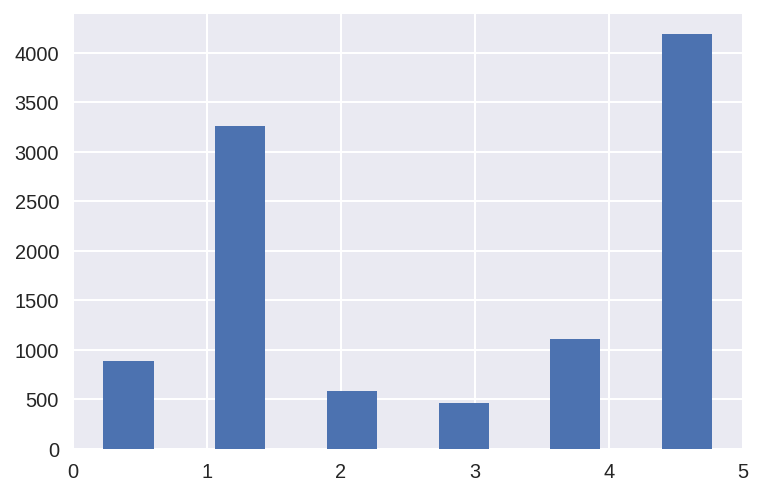

In [18]:
plt.hist(y, bins=6, rwidth=0.45, )

In [0]:
classes = len(df['ActivityEncoded'].unique())

In [20]:
y_hot = np_utils.to_categorical(y, classes)
y_hot.shape

(10469, 6)

In [21]:
y_hot[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size = 0.2)
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.6189111747851003

In [25]:
X_train.shape, y_train.shape

((8375, 100), (8375, 6))

In [0]:
rfc = RandomForestClassifier(n_estimators=100) 
cross_val_score(rfc, X = X, y = y_hot, cv = 5)  

array([0.48, 0.51, 0.41, 0.45, 0.49])

In [44]:
model_m = Sequential()
# model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu', input_shape=(100,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
# model_m.add(Flatten())
model_m.add(Dense(classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 606       
Total params: 30,906
Trainable params: 30,906
Non-trainable params: 0
_________________________________________________________________
None


## 동작 환경 설정
- 조기 종료 (2회 동안 개선되지 않으면 종료)
- 배키 크기 400
- 이포크 50
- 훈련데이터: 검증 데이터 = 8:2


In [45]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 10
EPOCHS = 30

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 4s 597us/step - loss: 0.8571 - acc: 0.6710 - val_loss: 0.5856 - val_acc: 0.7982
Epoch 2/30
6700/6700 [==============================] - 3s 515us/step - loss: 0.5251 - acc: 0.8064 - val_loss: 0.5437 - val_acc: 0.8155
Epoch 3/30
6700/6700 [==============================] - 3s 512us/step - loss: 0.4112 - acc: 0.8518 - val_loss: 0.5740 - val_acc: 0.8233
Epoch 4/30
6700/6700 [==============================] - 3s 514us/step - loss: 0.3306 - acc: 0.8725 - val_loss: 0.6155 - val_acc: 0.8239
Epoch 5/30
6700/6700 [==============================] - 3s 511us/step - loss: 0.2716 - acc: 0.9004 - val_loss: 0.6969 - val_acc: 0.8060
Epoch 6/30
6700/6700 [==============================] - 3s 516us/step - loss: 0.2270 - acc: 0.9190 - val_loss: 0.7162 - val_acc: 0.8137
Epoch 7/30
6700/6700 [==============================] - 3s 513us/step - loss: 0.1754 - acc: 0.9355 - val_loss: 0.7874 - val_acc: 0.8191


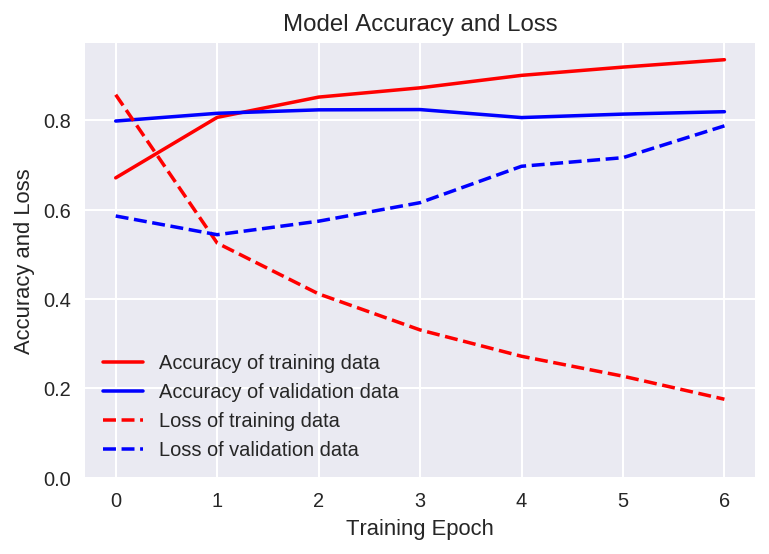

In [58]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [49]:
y_pred_train[:3]

array([[1.35e-01, 5.73e-04, 4.79e-05, 1.38e-07, 8.29e-01, 3.49e-02],
       [7.56e-02, 3.42e-02, 7.79e-07, 4.84e-09, 8.25e-01, 6.56e-02],
       [2.27e-05, 8.54e-07, 1.04e-13, 9.13e-18, 4.38e-06, 1.00e+00]],
      dtype=float32)

In [50]:
np.argmax(y_pred_train[:3], axis=1)

array([4, 4, 5])

In [51]:
y_train[:3]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


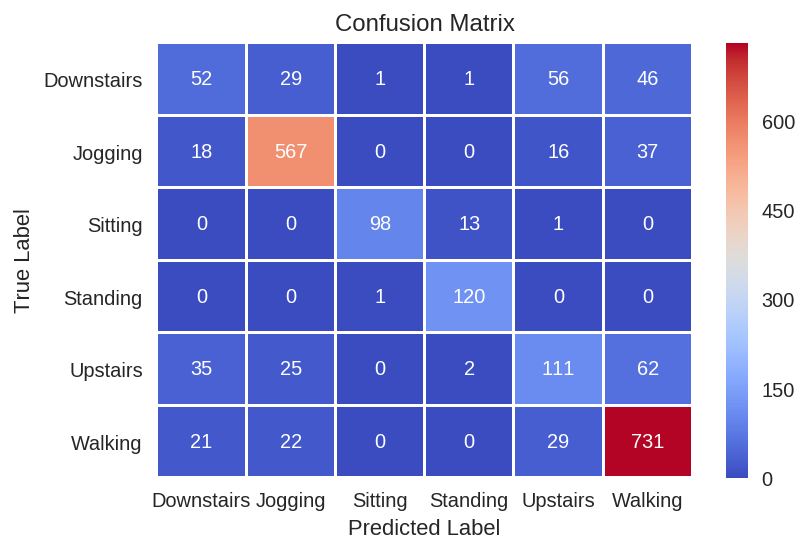

              precision    recall  f1-score   support

           0       0.41      0.28      0.33       185
           1       0.88      0.89      0.89       638
           2       0.98      0.88      0.92       112
           3       0.88      0.99      0.93       121
           4       0.52      0.47      0.50       235
           5       0.83      0.91      0.87       803

   micro avg       0.80      0.80      0.80      2094
   macro avg       0.75      0.74      0.74      2094
weighted avg       0.79      0.80      0.79      2094



In [59]:
y_pred_test = model_m.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

## Conv1D를 사용하여 성능을 개선

In [70]:
model_m = Sequential()
model_m.add(Reshape((N, 1), input_shape=(100,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(100,1)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 91, 100)           1100      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 82, 100)           100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 27, 100)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 18, 160)           160160    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 9, 160)            256160    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 160)               0         
__________

In [71]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 7s 1ms/step - loss: 0.7465 - acc: 0.7088 - val_loss: 0.3931 - val_acc: 0.8537
Epoch 2/30
6700/6700 [==============================] - 3s 501us/step - loss: 0.4216 - acc: 0.8458 - val_loss: 0.3191 - val_acc: 0.8884
Epoch 3/30
6700/6700 [==============================] - 3s 510us/step - loss: 0.3205 - acc: 0.8824 - val_loss: 0.2769 - val_acc: 0.9051
Epoch 4/30
6700/6700 [==============================] - 3s 510us/step - loss: 0.2443 - acc: 0.9060 - val_loss: 0.2714 - val_acc: 0.8896
Epoch 5/30
6700/6700 [==============================] - 3s 511us/step - loss: 0.2083 - acc: 0.9227 - val_loss: 0.2559 - val_acc: 0.9128
Epoch 6/30
6700/6700 [==============================] - 3s 508us/step - loss: 0.1752 - acc: 0.9325 - val_loss: 0.3156 - val_acc: 0.8997
Epoch 7/30
6700/6700 [==============================] - 3s 510us/step - loss: 0.1467 - acc: 0.9475 - val_loss: 0.2401 - val_acc: 0.9200
Ep

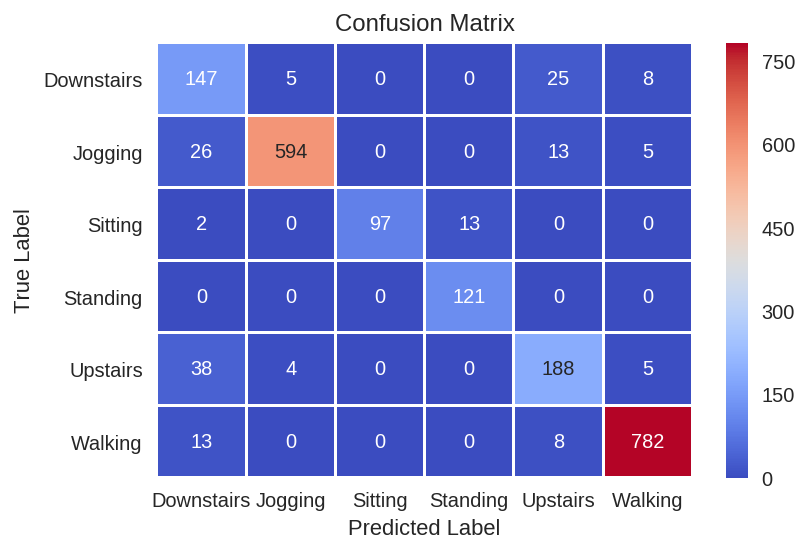

              precision    recall  f1-score   support

           0       0.65      0.79      0.72       185
           1       0.99      0.93      0.96       638
           2       1.00      0.87      0.93       112
           3       0.90      1.00      0.95       121
           4       0.80      0.80      0.80       235
           5       0.98      0.97      0.98       803

   micro avg       0.92      0.92      0.92      2094
   macro avg       0.89      0.89      0.89      2094
weighted avg       0.93      0.92      0.92      2094



In [72]:
y_pred_test = model_m.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# RNN으로 학습

In [0]:
from keras.layers import GRU
model = Sequential()
model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model.add(GRU(512, return_sequences=True, input_shape=(TIME_PERIODS,num_sensors)))
model.add(Dropout(0.2))
model.add(GRU(512))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
gru_7 (GRU)                  (None, 80, 512)           792576    
_________________________________________________________________
dropout_9 (Dropout)          (None, 80, 512)           0         
_________________________________________________________________
gru_8 (GRU)                  (None, 512)               1574400   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 3078      
Total params: 2,370,054
Trainable params: 2,370,054
Non-trainable params: 0
_________________________________________________________________


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 30s 2ms/step - loss: 1.3805 - acc: 0.4179 - val_loss: 1.3235 - val_acc: 0.4631
Epoch 2/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.2399 - acc: 0.5168 - val_loss: 1.0890 - val_acc: 0.6703
Epoch 3/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.2815 - acc: 0.6149 - val_loss: 0.7977 - val_acc: 0.7568
Epoch 4/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7912 - acc: 0.7279 - val_loss: 0.7446 - val_acc: 0.7784
Epoch 5/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7530 - acc: 0.7363 - val_loss: 0.7701 - val_acc: 0.7626
Epoch 6/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7012 - acc: 0.7449 - val_loss: 0.6521 - val_acc: 0.7760
Epoch 7/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.5902 - acc: 0.7838 - val_loss: 0.6652 - val_acc:

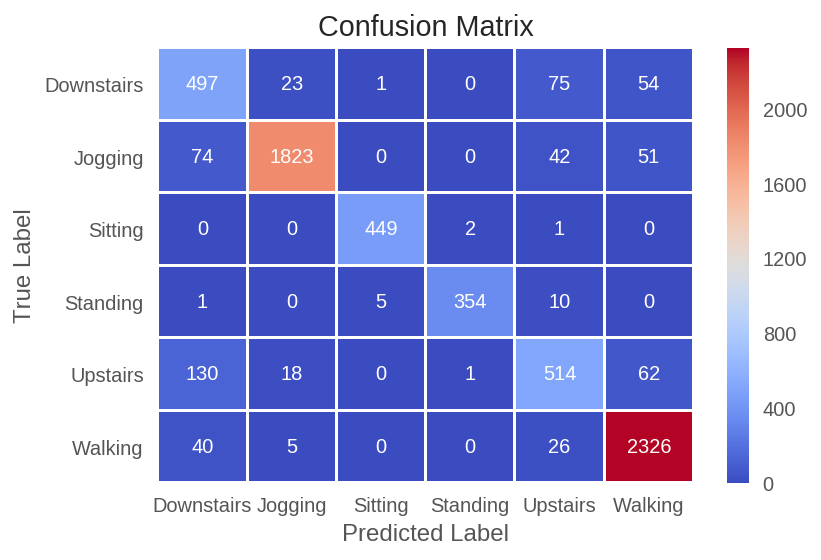

              precision    recall  f1-score   support

         0.0       0.67      0.76      0.71       650
         1.0       0.98      0.92      0.94      1990
         2.0       0.99      0.99      0.99       452
         3.0       0.99      0.96      0.97       370
         4.0       0.77      0.71      0.74       725
         5.0       0.93      0.97      0.95      2397

   micro avg       0.91      0.91      0.91      6584
   macro avg       0.89      0.89      0.89      6584
weighted avg       0.91      0.91      0.91      6584



In [0]:
history = model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
show_confusion_matrix(y_test, max_y_pred_test)
print(classification_report(y_test, max_y_pred_test))

# x,y값만 가지고 학습할때

In [0]:
x_train = x_train.reshape(-1,80,3)
x_test = x_test.reshape(-1,80,3)

In [0]:
x_train.shape

(20868, 80, 3)

In [0]:
x_train_2 = x_train[:,:,0:2]
x_test_2 = x_test[:,:,0:2]
x_test_2.shape, x_train_2.shape

((6584, 80, 2), (20868, 80, 2))

In [0]:
model = Sequential()
model.add(Reshape((TIME_PERIODS, 2), input_shape=(TIME_PERIODS,2)))
model.add(GRU(512, return_sequences=True, input_shape=(TIME_PERIODS,2)))
model.add(Dropout(0.2))
model.add(GRU(512))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 80, 2)             0         
_________________________________________________________________
gru_9 (GRU)                  (None, 80, 512)           791040    
_________________________________________________________________
dropout_11 (Dropout)         (None, 80, 512)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 512)               1574400   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 3078      
Total params: 2,368,518
Trainable params: 2,368,518
Non-trainable params: 0
_________________________________________________________________


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 30s 2ms/step - loss: 1.3721 - acc: 0.4346 - val_loss: 1.2341 - val_acc: 0.5954
Epoch 2/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.3211 - acc: 0.4983 - val_loss: 1.4348 - val_acc: 0.5031
Epoch 3/50
16694/16694 [==============================] - 28s 2ms/step - loss: 1.2879 - acc: 0.4838 - val_loss: 1.1850 - val_acc: 0.6938
Epoch 4/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.9942 - acc: 0.6777 - val_loss: 0.8042 - val_acc: 0.7702
Epoch 5/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7836 - acc: 0.7239 - val_loss: 0.7262 - val_acc: 0.7640
Epoch 6/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.6723 - acc: 0.7567 - val_loss: 0.8373 - val_acc: 0.7686
Epoch 7/50
16694/16694 [==============================] - 28s 2ms/step - loss: 0.7303 - acc: 0.7515 - val_loss: 0.6800 - val_acc:

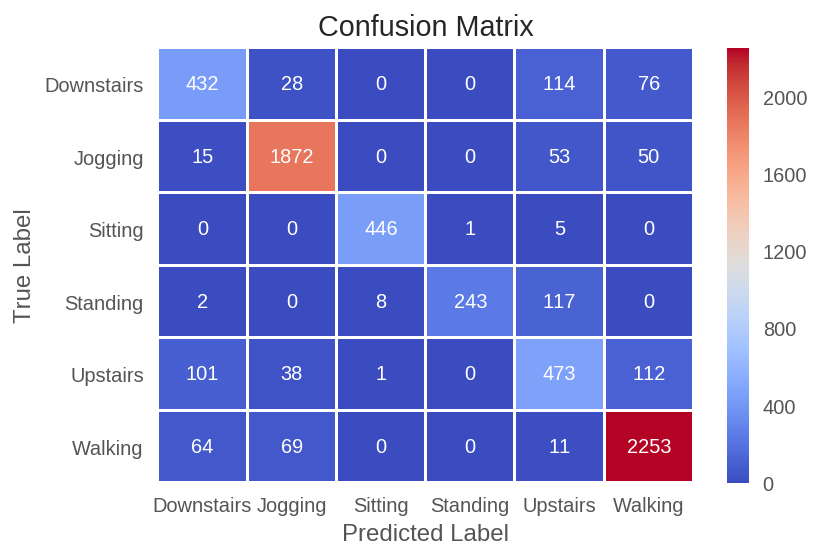

              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68       650
         1.0       0.93      0.94      0.94      1990
         2.0       0.98      0.99      0.98       452
         3.0       1.00      0.66      0.79       370
         4.0       0.61      0.65      0.63       725
         5.0       0.90      0.94      0.92      2397

   micro avg       0.87      0.87      0.87      6584
   macro avg       0.85      0.81      0.82      6584
weighted avg       0.87      0.87      0.87      6584



In [0]:
history = model.fit(x_train_2,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(x_test_2)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
show_confusion_matrix(y_test, max_y_pred_test)
print(classification_report(y_test, max_y_pred_test))